In [34]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [35]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [54]:
# Load dicom dataframe
df = pd.read_feather('../../Data/cleaned_dicom_df.feather')
df.head()

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,SliceThickness,PixelArrayFile
0,ANONYM-XT8UJZ,64,M,80.0,1.81,Ganzkörper,512,512,487,0.976562,4.0,Scan_1.npy
1,ANONYM-XT8UJZ_1,56,M,73.0,1.71,Stamm,512,512,567,1.171875,3.0,Scan_2.npy
2,ANONYM-XT8UJZ_2,19,F,43.0,1.63,Kopf/Stamm,512,512,323,0.976562,3.0,Scan_3.npy
3,ANONYM-XT8UJZ_3,77,F,74.0,1.63,Hirn,512,512,119,1.171875,3.0,Scan_4.npy
4,ANONYM-XT8UJZ_3,77,F,74.0,1.63,Stamm,512,512,567,1.171875,3.0,Scan_5.npy


In [37]:
# Load Pixelarray
def load_pixel_array(scan_id):
    path = f'../../Data/PixelArray/{scan_id}'
    return np.load(path)

In [38]:
scan = df.iloc[1]
#array = scan['PixelArrayFlat'].reshape((scan['SliceCount'], scan['Rows'], scan['Columns']))
#pixel_array = np.load(f'../../Data/PixelArray/{scan["PixelArrayFile"]}')
pixel_array = load_pixel_array(scan["PixelArrayFile"])
print("Array shape:", pixel_array.shape)
print("Scan shape:", (scan['SliceCount'], scan['Rows'], scan['Columns']))
print("PixelSpacing:", scan['PixelSpacing'], "SliceThickness:", scan['SliceThickness'])
# pixel aspects, assuming all slices are the same
pixel_spacing = scan.PixelSpacing
slice_thickness = scan.SliceThickness
ax_aspect = pixel_spacing[1] / pixel_spacing[0]
sag_aspect = pixel_spacing[1] / slice_thickness
cor_aspect = slice_thickness / pixel_spacing[0]

Array shape: (567, 512, 512)
Scan shape: (567, 512, 512)
PixelSpacing: [1.171875 1.171875] SliceThickness: 3.0


In [39]:
# Get pixel arrays, weights and dimensions from dataframe
#pixel_arrays = df['PixelArrayFlat'].values
#pixel_arrays = pixel_array.flatten()
# flat the pixel_array to an one dimensional array
dfTest = df.head(10)
pixel_arrays = dfTest['PixelArrayFile'].apply(load_pixel_array).apply(lambda x: x.flatten()).values
patient_weights = dfTest['PatientWeight'].values
dimensions = dfTest[['SliceCount','Rows', 'Columns']]

In [40]:
pixel_arrays[0].shape

(127664128,)

In [42]:
# Reshape pixel arrays to 3D arrays
pixel_arrays = [pa.reshape(dimensions.iloc[i]) for i, pa in enumerate(pixel_arrays)]
pixel_arrays[0].shape

(487, 512, 512)

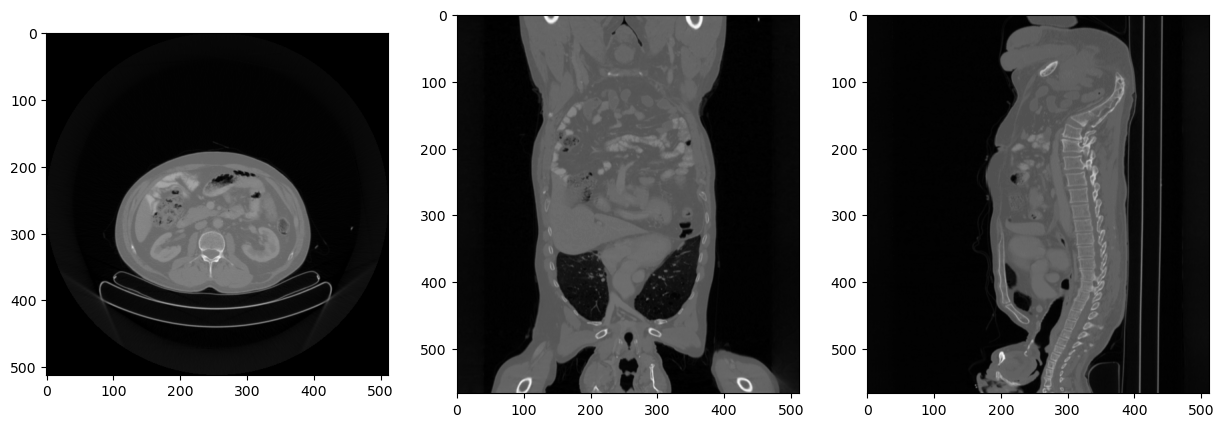

In [44]:
# plot mid point planes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(pixel_arrays[1][dimensions.iloc[0,0]//2], cmap='gray')
axs[1].imshow(pixel_arrays[1][:,dimensions.iloc[0,1]//2], cmap='gray')
axs[2].imshow(pixel_arrays[1][:,:,dimensions.iloc[0,2]//2], cmap='gray')
plt.show()

In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
import cv2
import glob

In [48]:
#Standardize the pixel values
def background_removed(img, display=False,erosion = 2,dilation = 1):
    cropping_error = False
    # Find the average pixel value close to foreground to renormalize washed out images 
    img= cv2.copyMakeBorder(img,1,1,0,0,cv2.BORDER_WRAP)
    img= cv2.copyMakeBorder(img,25,25,25,25,cv2.BORDER_CONSTANT,value=0)
    
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # finding the threshold to separate foreground (soft tissue / bone) and background (lung/air)
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1])) # kmeans
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate 
    # to include some of the pixels surrounding the lung.  
    # We want to aviod accidentally cliping the lung.
    eroded = morphology.erosion(thresh_img,np.ones([erosion,erosion]))
    dilated = morphology.dilation(eroded,np.ones([dilation,dilation]))
      
    h, w = dilated.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    dilated =dilated.astype('uint8')
    foreground1 = 1- dilated  # first foreground mask
    
    # Find the largest contour in intermediate image
    cnts, _ = cv2.findContours(foreground1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)
    
    foreground2 = np.zeros(img.shape, np.uint8)
    cv2.drawContours(foreground2, [cnt], -1, 255, cv2.FILLED) # second foreground mask
    
    # Intersection of the two foreground masks 
    foreground = cv2.bitwise_and(foreground1, foreground2)  # Bitwise AND operation of the two images 
    
    # filling the holes in the enclosed mask   
    cv2.floodFill(foreground,mask, (0,0), 1) 

    masked = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')  
    masked = (1-mask[:row_size,:col_size]) * masked # Applying the mask on the image
    
    # Cropping the masked image 
    _,thresh = cv2.threshold(masked,1,255,cv2.THRESH_BINARY)
    contours , hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x),reverse = True)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = masked[y:y+h,x:x+w]
    mas = 1-mask[:row_size,:col_size]
    crop_mask = mas[y:y+h,x:x+w]
    
    nonzero = np.where ((crop_mask ==1))
    crop[nonzero] = ((crop[nonzero] - crop[nonzero].min()) * (1/(crop[nonzero].max() - crop[nonzero].min()) * 255)).astype('uint8')
    
    if crop.shape[0] * crop.shape[1] < int( row_size * col_size / 27) :
        cropping_error = True
           
    return crop , cropping_error

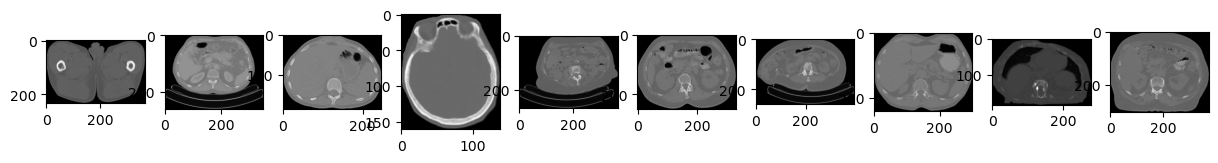

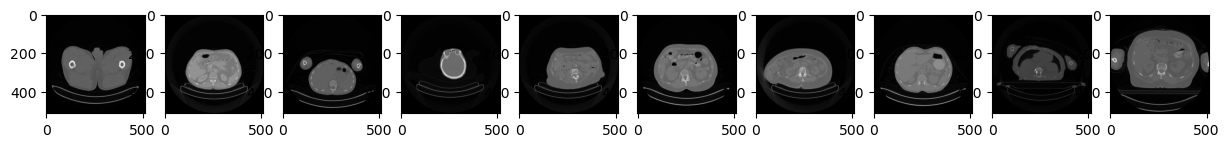

In [53]:
# use background_removed function to remove background for the first 10 scans
cropped_images = []
cropping_errors = []
for i in range(10):
    img, cropping_error = background_removed(pixel_arrays[i][dimensions.iloc[i,0]//2], display=False)
    cropped_images.append(img)
    cropping_errors.append(cropping_error)

# plot cropped images
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axs[i].imshow(cropped_images[i], cmap='gray')
plt.show()

# plot original images
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axs[i].imshow(pixel_arrays[i][dimensions.iloc[i,0]//2], cmap='gray')

plt.show()